In [1]:
%%capture
#from jupyterthemes import jtplot
#jtplot.style()
import numpy as np
import operator
import seaborn as sns; sns.set()
from landlab import FieldError
from landlab.utils import get_watershed_mask
import xarray as xr
import pandas as pd
import scipy
import gdal
from scipy import ndimage
from scipy.ndimage.filters import *
import os
import math
from osgeo import osr
from fractions import Fraction
import timeit
import matplotlib.pyplot as plt
%matplotlib inline
import random
# import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl
from pylab import show, figure


In [2]:
input_location = (r'C:\PhD\alluvial_fans')
os.chdir(input_location)

In [45]:
gh_data = pd.read_excel('fan_data_v2.xlsx', index_col=0)
gh_variability = pd.read_excel('variability_data.xlsx', index_col=0)

In [6]:
gh_data_05m = gh_data[gh_data['Resolution'] == 'half meter']

In [7]:
gh_data_1m = gh_data[gh_data['Resolution'] == 'one meter']

In [8]:
gh_data_2m = gh_data[gh_data['Resolution'] == 'two meter']

In [9]:
gh_data.head()

,Gully,Area,Method,Catchment area (ha),Resolution,G1,G2,G1 Slope,G2 Slope,Min area,Max area,Mean slope
Record,,,,,,,,,,,,
1,1,2.117061,M8,8.030,half meter,3.93,4.100,0.026,0.020,3.930,4.10,0.023
2,2,56.078431,M8,2.550,half meter,0.56,1.990,0.050,0.052,0.560,1.99,0.051
3,3,97.034596,M8,6.070,half meter,5.98,0.090,0.018,0.020,0.090,5.98,0.019
4,4,45.960035,M8,2.302,half meter,1.68,0.622,0.034,0.034,0.622,1.68,0.034
5,5,22.554890,M8,5.010,half meter,1.94,3.070,0.036,0.038,1.940,3.07,0.037


Text(0.5, 1.0, 'Partitioning behaviour of routing algorithms')

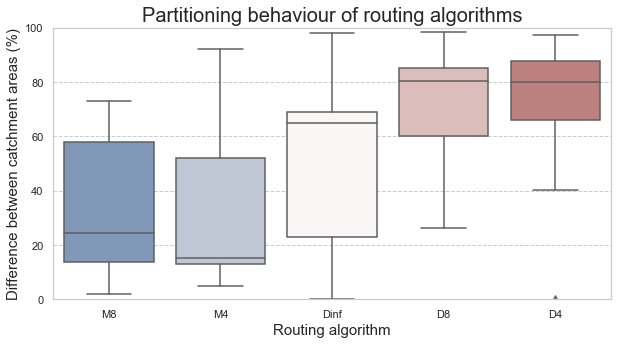

In [10]:
# Plot miles per gallon against horsepower with other semantics
sns.set_style("whitegrid", {'grid.linestyle': '--'})
fig, ax = plt.subplots(figsize = (10, 5))
sns.boxplot(x="Method", y="Area", palette="vlag", data=gh_data_1m)

ax.set_ylabel('Difference between catchment areas (%)', fontsize = 15)
ax.set_xlabel('Routing algorithm', fontsize = 15)
ax.set_ylim(0, 100)
plt.title('Partitioning behaviour of routing algorithms', fontsize = 20)

In [121]:
gh_data

,Gully,Area,Method,Catchment area (ha),Resolution,G1,G2,G1 Slope,G2 Slope,Min area,Max area,Mean slope
Record,,,,,,,,,,,,
1,1,2.117061,M8,8.030,half meter,3.930,4.100,0.026,0.020,3.930,4.10,0.023
2,2,56.078431,M8,2.550,half meter,0.560,1.990,0.050,0.052,0.560,1.99,0.051
3,3,97.034596,M8,6.070,half meter,5.980,0.090,0.018,0.020,0.090,5.98,0.019
4,4,45.960035,M8,2.302,half meter,1.680,0.622,0.034,0.034,0.622,1.68,0.034
5,5,22.554890,M8,5.010,half meter,1.940,3.070,0.036,0.038,1.940,3.07,0.037
...,...,...,...,...,...,...,...,...,...,...,...,...
191,9,49.494949,D4,0.990,two meter,0.740,0.250,0.050,0.050,0.250,0.74,0.050
192,10,31.666667,D4,1.200,two meter,0.410,0.790,0.030,0.030,0.410,0.79,0.030
193,11,17.241379,D4,1.160,two meter,0.680,0.480,0.030,0.024,0.480,0.68,0.027


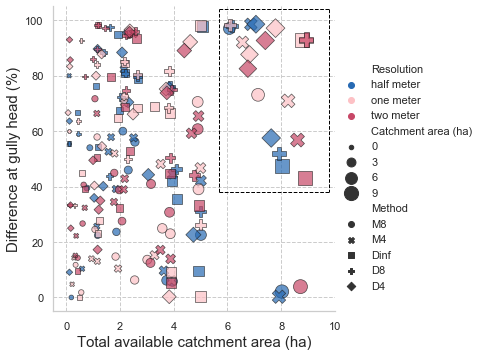

In [11]:
sns.set_style('whitegrid', {'grid.linestyle': '--'})

colours = {'half meter':'xkcd:mid blue', 'one meter':'xkcd:pale rose', 'two meter':'xkcd:deep rose'}

g = sns.relplot(x="Catchment area (ha)", y="Area", size = "Catchment area (ha)",  sizes=(20, 200),style = 'Method', palette = colours,
                hue = 'Resolution', data=gh_data, alpha = 0.7, legend = 'brief', edgecolor="k")

ax = g.axes[0,0]
ax.set_xlim(-0.5,10)
ax.set_ylim(-5,105)
ax.set_xlabel('Total available catchment area (ha)', fontsize = 15)
ax.set_ylabel('Difference at gully head (%)', fontsize = 15)
leg = g._legend
plt.rcParams["axes.edgecolor"] = "0.15"
plt.plot([5.7, 5.7], [38, 104], linestyle = '--',color = 'xkcd:black',linewidth=1.0)
plt.plot([5.7, 9.8], [38, 38], linestyle = '--',color = 'xkcd:black',linewidth=1.0)
plt.plot([5.7, 9.8], [104, 104], linestyle = '--',color = 'xkcd:black',linewidth=1.0)
plt.plot([9.8, 9.8], [104, 38], linestyle = '--',color = 'xkcd:black',linewidth=1.0)

In [12]:
import itertools

[None, None]

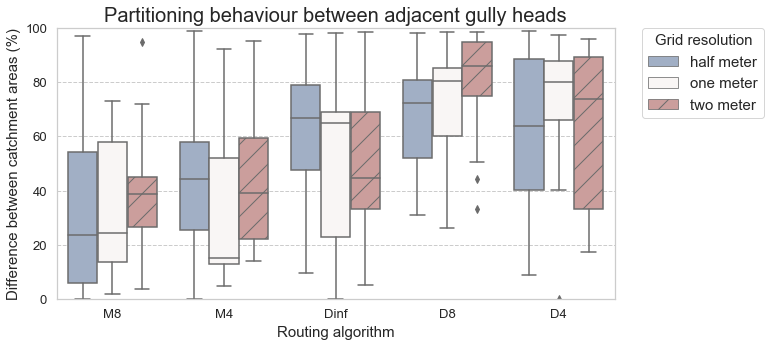

In [46]:
# Plot miles per gallon against horsepower with other semantics
sns.set(font_scale = 1.2)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

fig, ax = plt.subplots(figsize = (10, 5))
g = sns.boxplot(x="Method", y="Area", palette="vlag", hue = 'Resolution', data=gh_variability)

ax.set_ylabel('Difference between catchment areas (%)', fontsize = 15)
ax.set_xlabel('Routing algorithm', fontsize = 15)
ax.set_ylim(0, 100)
plt.title('Partitioning behaviour between adjacent gully heads', fontsize = 20)

hatches = ["", "", "/", "", "", "/", "", "", "/", "", "", "/", "", "", "/"]
for hatch, patch in zip(hatches, g.artists):
    patch.set_hatch(hatch)
    
hatches = ["", "", "/"]

# Loop over the bars
for i,thisbar in enumerate(g.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title = 'Grid resolution',fontsize='15')
plt.setp(ax.get_legend().get_title(), fontsize='15') # for legend title



In [13]:
m8_sub = gh_data.iloc[0:,1:4].values
m4_sub = gh_data.iloc[0:,4:7].values
dinf_sub = gh_data.iloc[0:,7:10].values
d8_sub = gh_data.iloc[0:,10:13].values
d4_sub = gh_data.iloc[0:,13:16].values

In [229]:
m8_range = np.ptp(m8_sub, axis = 1)
m4_range = np.ptp(m4_sub, axis = 1)
dinf_range = np.ptp(dinf_sub, axis = 1)
d8_range = np.ptp(d8_sub, axis = 1)
d4_range = np.ptp(d4_sub, axis = 1)

In [230]:
gh_data['M8 Range'] = m8_range
gh_data['M4 Range'] = m4_range
gh_data['Dinf Range'] = dinf_range
gh_data['D8 Range'] = d8_range
gh_data['D4 Range'] = d4_range

In [5]:
gh_data['Log10 Area'] = np.log10(gh_data.loc[:,'Area (ha)'].values)

In [6]:
gh_data['Log10 Slope'] = np.log10(gh_data.loc[:,'Slope (%)'].values)

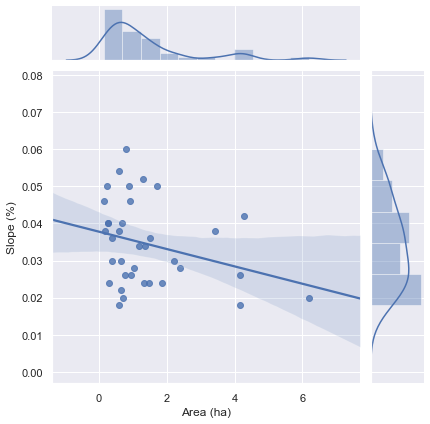

In [8]:
ax = sns.jointplot(x="Area (ha)", y="Slope (%)", data=gh_data, kind = 'reg')
#ax.set(xscale="log", yscale="log")
#ax.set_ylim(-1, 10)
#ax.set(xlim = (-10,10))


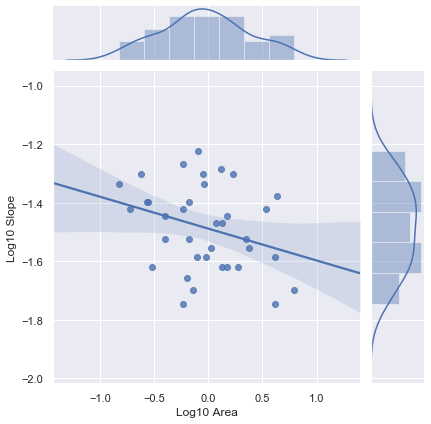

In [9]:
ax = sns.jointplot(x="Log10 Area", y="Log10 Slope", data=gh_data, kind = 'reg')
#ax.set(xscale="log", yscale="log")
#ax.set_ylim(-1, 10)
#ax.set(xlim = (-10,10))


In [21]:
catchment_areas_05 = gh_data[['M8 0.5m', 'M4 0.5m','Dinf 0.5m','D8 0.5m','D4 0.5m']]
catchment_areas_1 = gh_data[['M8 1m', 'M4 1m','Dinf 1m','D8 1m','D4 1m']]
catchment_areas_2 = gh_data[['M8 2m', 'M4 2m','Dinf 2m','D8 2m','D4 2m']]

In [22]:
A_05 = catchment_areas_05.rename(columns={'M8 0.5m':'M8', 'M4 0.5m':'M4', 'Dinf 0.5m':'Dinf', 'D8 0.5m':'D8', 'D4 0.5m':'D4'})
A_1 = catchment_areas_1.rename(columns={'M8 1m':'M8', 'M4 1m':'M4', 'Dinf 1m':'Dinf', 'D8 1m':'D8', 'D4 1m':'D4'})
A_2 = catchment_areas_2.rename(columns={'M8 2m':'M8', 'M4 2m':'M4', 'Dinf 2m':'Dinf', 'D8 2m':'D8', 'D4 2m':'D4'})

In [23]:
A_05['Grid resolution'] = '1/2 meter'
A_1['Grid resolution'] = '1 meter'
A_2['Grid resolution'] = '2 meter'

In [24]:
A_05['Numeric resolution'] = 0.5
A_1['Numeric resolution'] = 1
A_2['Numeric resolution'] = 2

In [25]:
area_data = pd.concat([A_05, A_1, A_2])

In [26]:
area_data

,M8,M4,Dinf,D8,D4,Grid resolution,Numeric resolution
DEM,,,,,,,
f1,3.93,3.97,5.92,6.02,6.010,1/2 meter,0.5
f1a,4.10,3.95,2.11,1.90,1.620,1/2 meter,0.5
f2,0.41,0.31,0.48,0.24,0.100,1/2 meter,0.5
f3,0.56,0.53,0.28,0.27,2.250,1/2 meter,0.5
f3a,1.99,1.97,2.38,2.37,0.050,1/2 meter,0.5
...,...,...,...,...,...,...,...
f22,0.80,0.56,0.71,0.17,1.290,2 meter,2.0
f24,0.22,0.19,0.28,0.02,0.004,2 meter,2.0
f24a,0.38,0.14,0.85,1.42,0.110,2 meter,2.0


In [15]:
A_05['Resolution'] = 0.5
A_1['Resolution'] = 1
A_2['Resolution'] = 2

In [21]:
catchment_areas_05.head()

,M8 0.5m,M4 0.5m,Dinf 0.5m,D8 0.5m,D4 0.5m
DEM,,,,,
f1,3.93,3.97,5.92,6.02,6.01
f1a,4.10,3.95,2.11,1.90,1.62
f2,0.41,0.31,0.48,0.24,0.10
f3,0.56,0.53,0.28,0.27,2.25
f3a,1.99,1.97,2.38,2.37,0.05


In [17]:
testcat = pd.concat([A_05, A_1, A_2])

In [69]:
testcat

,M8,M4,Dinf,D8,D4,Resolution
DEM,,,,,,
f1,3.930,3.97,5.92,6.02,6.010,0.5
f1a,4.100,3.95,2.11,1.90,1.620,0.5
f2,0.410,0.31,0.48,0.24,0.100,0.5
f3,0.560,0.53,0.28,0.27,2.250,0.5
f3a,1.990,1.97,2.38,2.37,0.050,0.5
f4,0.510,0.48,0.32,0.28,0.210,0.5
f5a,0.660,0.63,0.86,0.88,1.140,0.5
f6,5.980,6.82,5.02,6.12,7.010,0.5
f6a,0.090,0.05,0.06,0.06,0.050,0.5


In [29]:
corr_05 = catchment_areas_05.corr()
corr_1 = catchment_areas_1.corr()
corr_2 = catchment_areas_2.corr()

In [19]:
corrtest = testcat.corr()

In [27]:

n_colors = 256 # Use 256 colors for the diverging color palette
palette = sns.diverging_palette(20, 220, n=n_colors) # Create the palette
color_min, color_max = [-1, 1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation

def value_to_color(val):
    val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
    ind = int(val_position * (n_colors - 1)) # target index in the color palette
    return palette[ind]

ax.scatter(
    x=corr_05.map(x_to_num),
    y=corr_05.map(y_to_num),
    s=size * size_scale,
    c=color.apply(value_to_color), # Vector of square color values, mapped to color palette
    marker='s'
)

NameError: name 'corr_05' is not defined

In [41]:
corr

,x,y,value
0,M8 0.5m,M8 0.5m,1.000000
1,M4 0.5m,M8 0.5m,0.978044
2,Dinf 0.5m,M8 0.5m,0.894294
3,D8 0.5m,M8 0.5m,0.862481
4,D4 0.5m,M8 0.5m,0.806716
5,M8 0.5m,M4 0.5m,0.978044
6,M4 0.5m,M4 0.5m,1.000000
7,Dinf 0.5m,M4 0.5m,0.836873
8,D8 0.5m,M4 0.5m,0.797729
9,D4 0.5m,M4 0.5m,0.837238


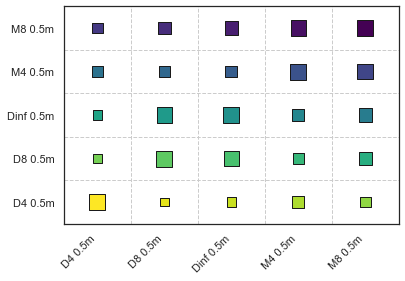

In [141]:
# Step 1 - Make a scatter plot with square markers, set column names as labels
n_colors = 256 # Use 256 colors for the diverging color palette
palette = sns.diverging_palette(20, 220, n=n_colors) # Create the palette
color_min, color_max = [-1, 1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation

def value_to_color(val):
    val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
    ind = int(val_position * (n_colors - 1)) # target index in the color palette
    return palette[ind]

def heatmap(x, y, size):
    fig, ax = plt.subplots()
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    t = np.arange(0, 1, 0.04)
    size_scale = 1000
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        marker='s', # Use square as scatterplot marker
        edgecolor='k',

        linewidth = 1
    )
    

    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5]) 
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])

    


data = gh_data
columns = ['M8 0.5m', 'M4 0.5m', 'Dinf 0.5m', 'D8 0.5m', 'D4 0.5m'] 
corr = corr_05
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']
values = corr['value'].values
max_val = np.amax(values)
min_val = np.amin(values) - 1.1
corr['norm_corr'] = ((corr['value'].values) - min_val - 1) / (max_val - min_val)

heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['norm_corr'].abs() 
)



In [137]:

t = np.arange(0, 1, 0.01)
t

array([ 0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,
        0.09,  0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,
        0.18,  0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,  0.25,  0.26,
        0.27,  0.28,  0.29,  0.3 ,  0.31,  0.32,  0.33,  0.34,  0.35,
        0.36,  0.37,  0.38,  0.39,  0.4 ,  0.41,  0.42,  0.43,  0.44,
        0.45,  0.46,  0.47,  0.48,  0.49,  0.5 ,  0.51,  0.52,  0.53,
        0.54,  0.55,  0.56,  0.57,  0.58,  0.59,  0.6 ,  0.61,  0.62,
        0.63,  0.64,  0.65,  0.66,  0.67,  0.68,  0.69,  0.7 ,  0.71,
        0.72,  0.73,  0.74,  0.75,  0.76,  0.77,  0.78,  0.79,  0.8 ,
        0.81,  0.82,  0.83,  0.84,  0.85,  0.86,  0.87,  0.88,  0.89,
        0.9 ,  0.91,  0.92,  0.93,  0.94,  0.95,  0.96,  0.97,  0.98,  0.99])

In [126]:

n_colors = 256 # Use 256 colors for the diverging color palette
palette = sns.diverging_palette(20, 220, n=n_colors) # Create the palette
color_min, color_max = [-1, 1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation

def value_to_color(val):
    val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
    ind = int(val_position * (n_colors - 1)) # target index in the color palette
    return palette[ind]

ax.scatter(
    x=x.map(x_to_num),
    y=y.map(y_to_num),
    s=size * size_scale,
    c=color.apply(value_to_color), # Vector of square color values, mapped to color palette
    marker='s'
)

AttributeError: 'float' object has no attribute 'map'

In [113]:
wc = W * 0.033 # to simplify S equation below
S = R * (4.17 - wc) - 0.36 # Average spotting distance (km)


[Text(0, 0.5, 'M8 0.5m'),
 Text(0, 1.5, 'M4 0.5m'),
 Text(0, 2.5, 'Dinf 0.5m'),
 Text(0, 3.5, 'D8 0.5m'),
 Text(0, 4.5, 'D4 0.5m')]

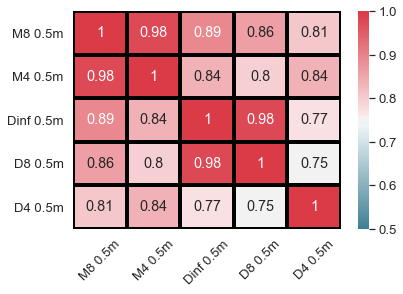

In [30]:
comparison = sns.heatmap(corr_05, xticklabels=corr_05.columns, yticklabels=corr_05.columns, annot = True,
            cmap=sns.diverging_palette(220, 10, as_cmap=True), vmin = 0.5, vmax = 1, linecolor = 'black', linewidths = 3)

comparison.set_xticklabels(comparison.get_xticklabels(), rotation=45)
comparison.set_yticklabels(comparison.get_yticklabels(), rotation=0)

[Text(0, 0.5, 'M8 1m'),
 Text(0, 1.5, 'M4 1m'),
 Text(0, 2.5, 'Dinf 1m'),
 Text(0, 3.5, 'D8 1m'),
 Text(0, 4.5, 'D4 1m')]

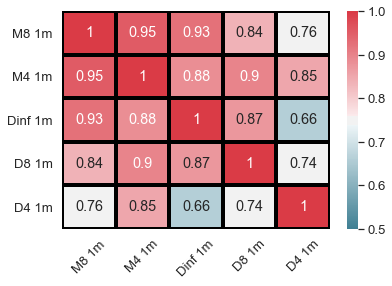

In [31]:
comparison = sns.heatmap(corr_1, xticklabels=corr_1.columns, yticklabels=corr_1.columns, annot = True,
            cmap=sns.diverging_palette(220, 10, as_cmap=True), vmax = 1, vmin = 0.5,linecolor = 'black', linewidths = 3)
#comparison.set_ylim(0, 1)
comparison.set_xticklabels(comparison.get_xticklabels(), rotation=45)
comparison.set_yticklabels(comparison.get_yticklabels(), rotation=0)

Text(0.5, 1, 'Routing method correlation')

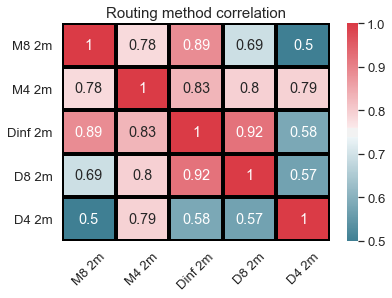

In [32]:
comparison = sns.heatmap(corr_2, xticklabels=corr_2.columns, yticklabels=corr_2.columns, annot = True,
            cmap=sns.diverging_palette(220, 10, as_cmap=True), vmax = 1, vmin = 0.5,linecolor = 'black', linewidths = 3)

comparison.set_xticklabels(comparison.get_xticklabels(), rotation=45)
comparison.set_yticklabels(comparison.get_yticklabels(), rotation=0)
plt.title('Routing method correlation', fontsize = 15)

In [33]:
catchment_areas_1.rename(columns = {'M8 1m':'M8','M4 1m':'M4','Dinf 1m':'Dinf','D8 1m':'D8','D4 1m':'D4'}).head()

,M8,M4,Dinf,D8,D4
DEM,,,,,
f1,0.96,1.20,0.31,0.32,0.42
f1a,6.18,7.06,8.45,8.61,6.40
f2,0.40,0.27,0.49,0.21,0.07
f3,1.71,1.89,0.42,0.26,2.32
f3a,1.30,1.39,2.23,2.39,0.04


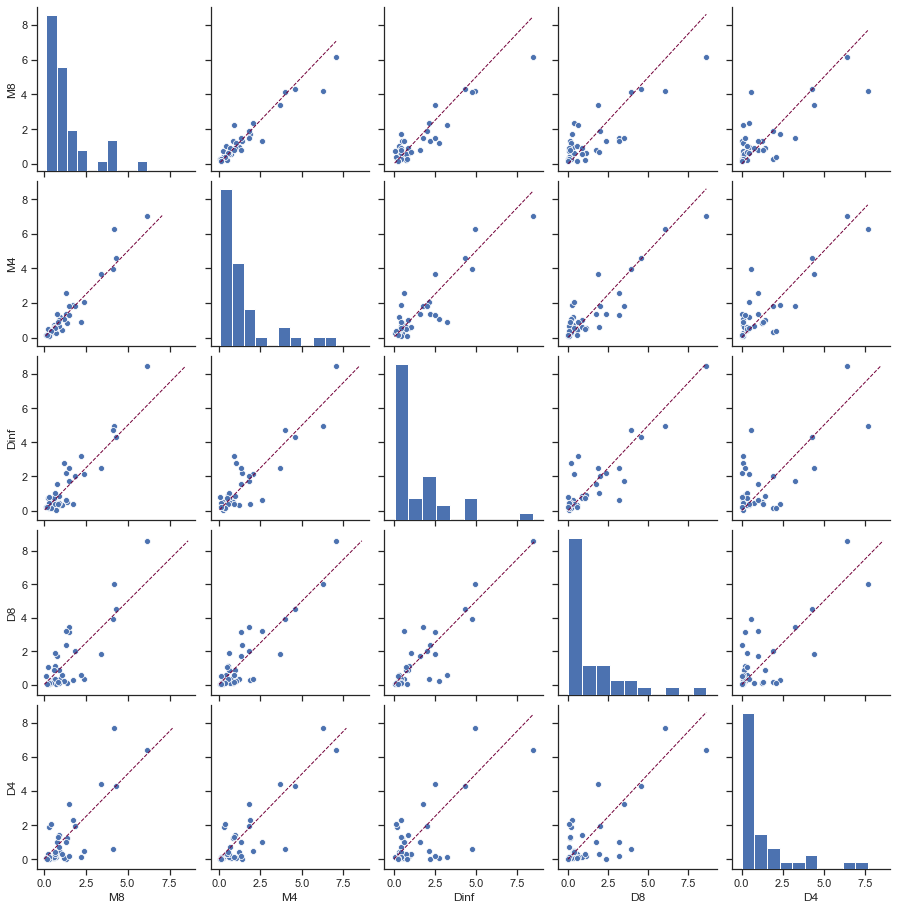

In [43]:

sns.set(style = "ticks")
def plot_unity(xdata, ydata, **kwargs):
    mn = min(xdata.min(), ydata.min())
    mx = max(xdata.max(), ydata.max())
    points = np.linspace(mn, mx, 100)
    plt.gca().plot(points, points, color = 'xkcd:merlot', marker=None,
            linestyle='--', linewidth=1.0)

g = sns.pairplot(catchment_areas_1.rename(columns = {'M8 1m':'M8','M4 1m':'M4','Dinf 1m':'Dinf','D8 1m':'D8','D4 1m':'D4'}))

sns.plotting_context()
g.map_offdiag(plot_unity)

#g.set(ylim=(-0.5,10))
#g.set(xlim=(-0.5,10))
#ax.set_ylabel('Difference between catchment areas (%)', fontsize = 15)


In [93]:
catchment_areas= gh_data[['M8 0.5m', 'M4 0.5m','Dinf 0.5m','D8 0.5m','D4 0.5m','M8 1m', 'M4 1m','Dinf 1m','D8 1m','D4 1m',
                            'M8 2m', 'M4 2m','Dinf 2m','D8 2m','D4 2m' ]]


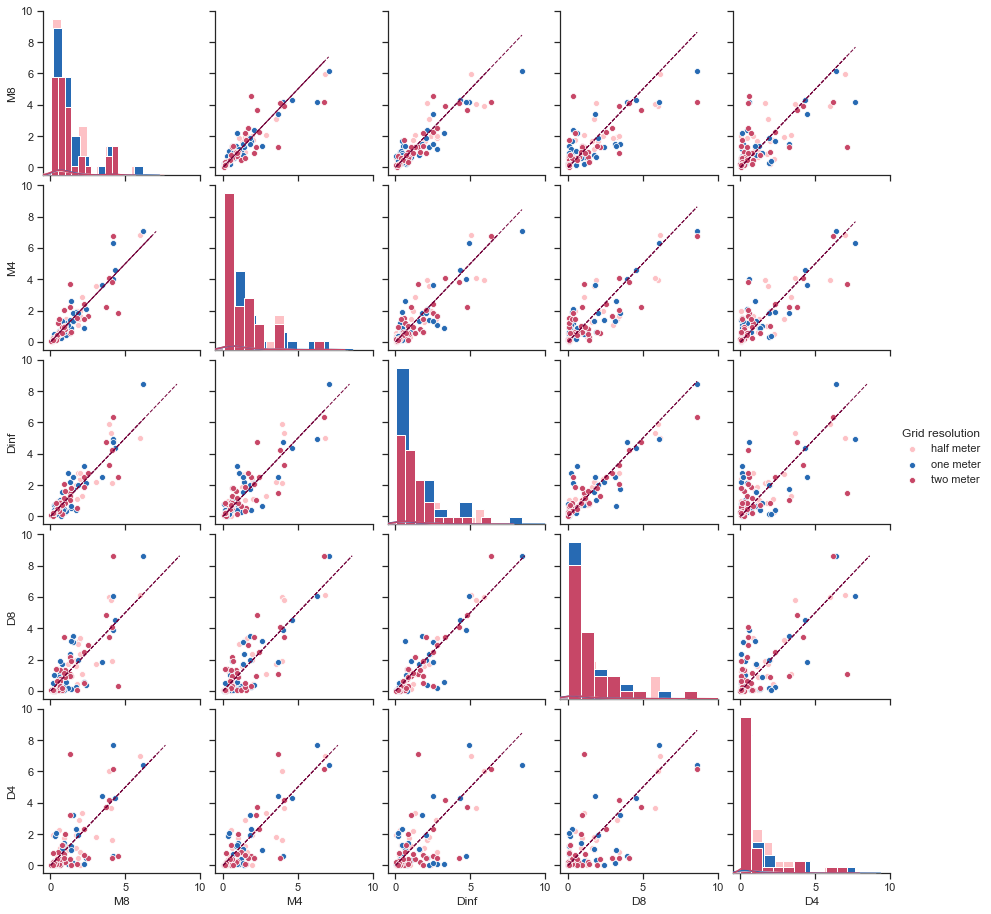

In [21]:
#sns.set(style = "whitegrid")
colours = {'half meter':'xkcd:pale rose', 'one meter':'xkcd:mid blue', 'two meter':'xkcd:deep rose'}
markers = {"half meter": "s","one meter": "s", "two meter": "X"}
def plot_unity(xdata, ydata, **kwargs):
    mn = min(xdata.min(), ydata.min())
    mx = max(xdata.max(), ydata.max())
    points = np.linspace(mn, mx, 100)
    plt.gca().plot(points, points, color = 'xkcd:merlot', marker=None,
            linestyle='--', linewidth=1.0)

#diag_kind = 'hist',
grid = sns.pairplot(area_data, hue = 'Grid resolution',  palette = colours)
grid.map_offdiag(plot_unity)
grid.map_diag(plt.hist)

grid.set(ylim=(-0.5,10))
grid.set(xlim=(-0.5,10))

array([ 3.93 ,  4.1  ,  0.41 ,  0.56 ,  1.99 ,  0.51 ,  0.66 ,  5.98 ,
        0.09 ,  1.68 ,  0.622,  1.94 ,  3.07 ,  4.06 ,  0.57 ,  0.71 ,
        1.15 ,  1.86 ,  2.09 ,  0.89 ,  0.38 ,  1.68 ,  0.42 ,  0.85 ,
        0.45 ,  0.71 ,  0.67 ,  0.2  ,  1.98 ,  1.75 ,  1.01 ,  0.8  ,
        0.53 ,  0.23 ,  0.09 ,  0.09 ,  0.96 ,  6.18 ,  0.4  ,  1.71 ,
        1.3  ,  0.59 ,  0.59 ,  4.17 ,  0.72 ,  1.35 ,  1.19 ,  1.5  ,
        3.42 ,  4.15 ,  0.64 ,  1.05 ,  0.78 ,  2.38 ,  1.49 ,  0.91 ,
        0.59 ,  1.87 ,  0.3  ,  0.67 ,  0.9  ,  0.24 ,  0.66 ,  0.4  ,
        2.23 ,  1.34 ,  4.29 ,  0.81 ,  0.28 ,  0.27 ,  0.15 ,  0.19 ,
        4.53 ,  4.19 ,  0.44 ,  2.26 ,  0.06 ,  0.67 ,  0.58 ,  1.32 ,
        0.75 ,  1.76 ,  1.37 ,  0.96 ,  3.93 ,  4.1  ,  0.67 ,  1.29 ,
        0.49 ,  2.51 ,  1.33 ,  0.97 ,  0.62 ,  1.36 ,  0.6  ,  0.62 ,
        0.91 ,  0.15 ,  0.45 ,  0.19 ,  2.22 ,  0.93 ,  3.7  ,  0.8  ,
        0.22 ,  0.38 ,  0.24 ,  0.18 ])

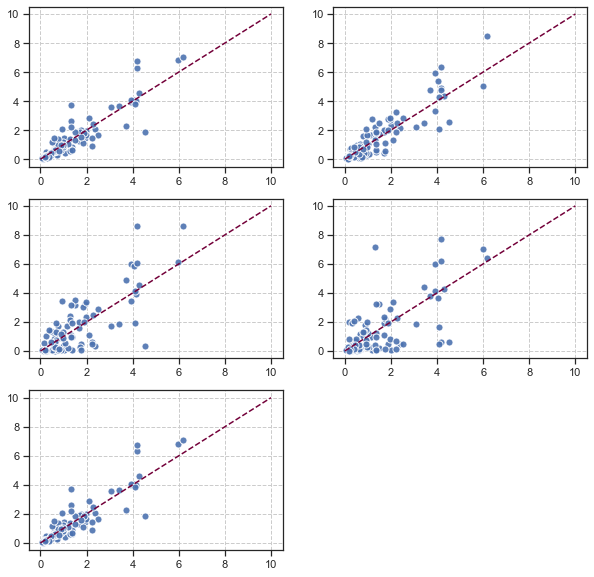

In [57]:
fig, ax = plt.subplots( figsize = (10, 10))

plt.subplot(321)
plt.scatter(area_data['M8'].values, area_data['M4'].values, s = 50, alpha = 0.9,cmap='Blue', edgecolors = 'white')
plt.plot([0, 10], [0, 10], linestyle='--', color = 'xkcd:merlot')
ax.set_xlabel('point (m)', fontsize = 15)
plt.grid(linestyle='--')
ax.set_ylim(0,10)
ax.set_xlim(0,10)
ax.set_xlabel='x axis label'

plt.subplot(322)
plt.scatter(area_data['M8'].values, area_data['Dinf'].values, s = 50, alpha = 0.9,cmap='Blue', edgecolors = 'white')
plt.plot([0, 10], [0, 10], linestyle='--', color = 'xkcd:merlot')
plt.grid(linestyle='--')
ax.set_ylim(0,10)
ax.set_xlim(0,10)

plt.subplot(323)
plt.scatter(area_data['M8'].values, area_data['D8'].values, s = 50, alpha = 0.9,cmap='Blue', edgecolors = 'white')
plt.plot([0, 10], [0, 10], linestyle='--', color = 'xkcd:merlot')
plt.grid(linestyle='--')
ax.set_ylim(0,10)
ax.set_xlim(0,10)

plt.subplot(324)
plt.scatter(area_data['M8'].values, area_data['D4'].values, s = 50, alpha = 0.9,cmap='Blue', edgecolors = 'white')
plt.plot([0, 10], [0, 10], linestyle='--', color = 'xkcd:merlot')
plt.grid(linestyle='--')
ax.set_ylim(0,10)
ax.set_xlim(0,10)

plt.subplot(325)
plt.scatter(area_data['M8'].values, area_data['M4'].values, s = 50, alpha = 0.9,cmap='Blue', edgecolors = 'white')
plt.plot([0, 10], [0, 10], linestyle='--', color = 'xkcd:merlot')
plt.grid(linestyle='--')
ax.set_ylim(0,10)
ax.set_xlim(0,10)
ax.set_xlabel='x axis label'



In [166]:
area_data['log M8'] = np.log10(area_data['M8'].values)

In [168]:
area_data['log D4'] = np.log10(area_data['D4'].values)

In [169]:
area_data.head()

,M8,M4,Dinf,D8,D4,Grid resolution,log M8,log D4
DEM,,,,,,,,
f1,3.93,3.97,5.92,6.02,6.01,half meter,0.594393,0.778874
f1a,4.10,3.95,2.11,1.90,1.62,half meter,0.612784,0.209515
f2,0.41,0.31,0.48,0.24,0.10,half meter,-0.387216,-1.000000
f3,0.56,0.53,0.28,0.27,2.25,half meter,-0.251812,0.352183
f3a,1.99,1.97,2.38,2.37,0.05,half meter,0.298853,-1.301030


(-0.1, 2)

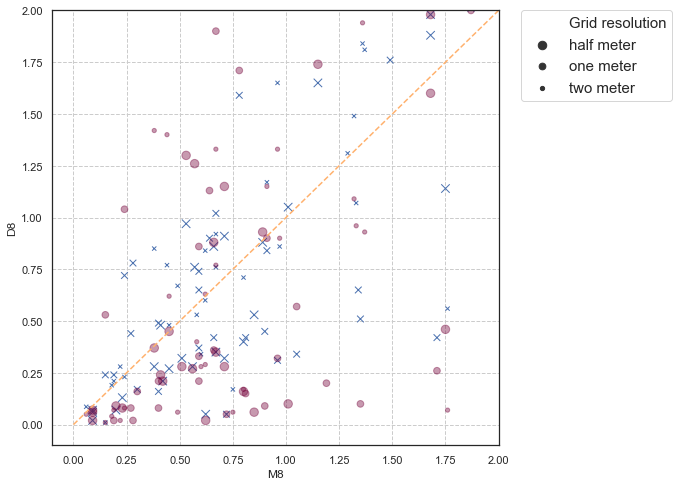

In [238]:
fig, ax = plt.subplots(figsize = (8, 8))
g0 = sns.scatterplot(x="M8", y="Dinf", marker = 'x', edgecolor= 'xkcd:royal blue', legend = False, 
                     linewidth = 1, size = 'Grid resolution',data=area_data)
g1 = sns.scatterplot(x="M8", y="D8", alpha=0.4, color='xkcd:merlot', edgecolor= 'xkcd:merlot', 
                     size = 'Grid resolution', linewidth = 1, data=area_data)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title = '',fontsize='15')
plt.setp(ax.get_legend().get_title(), fontsize='15') # for legend title
plt.plot([0, 10], [0, 10], linestyle='--', color = 'xkcd:apricot')
ax.set_ylim(-0.1,2)
ax.set_xlim(-0.1,2)


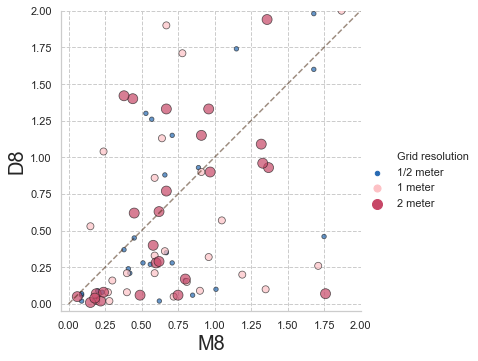

In [37]:
sns.set_style('whitegrid', {'grid.linestyle': '--'})

colours = {'1/2 meter':'xkcd:mid blue', '1 meter':'xkcd:pale rose', '2 meter':'xkcd:deep rose'}

sizes = {'1/2 meter':20, '1 meter': 50, '2 meter': 100}

g = sns.relplot(x="M8", y="D8", size = "Grid resolution", sizes = sizes, palette = colours, hue = 'Grid resolution',
                 data=area_data, alpha = 0.7, legend = 'brief', edgecolor="k")

ax = g.axes[0,0]
ax.set_xlim(-0.05,2)
ax.set_ylim(-0.05,2)
ax.set_xlabel('M8', fontsize = 20)
ax.set_ylabel('D8', fontsize = 20)
leg = g._legend
plt.rcParams["axes.edgecolor"] = "0.15"
plt.plot([0, 10], [0, 10], linestyle='--', color = 'xkcd:chocolate', alpha = 0.5)

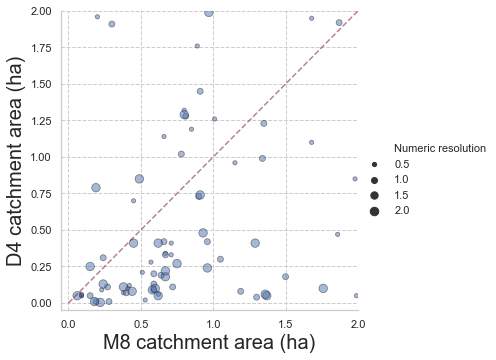

In [38]:
sns.set_style('whitegrid', {'grid.linestyle': '--'})

colours = {'half meter':'xkcd:deep rose', 'one meter':'xkcd:pale rose', 'two meter':'xkcd:mid blue'}
    
g = sns.relplot(x="M8", y="D4", size = "Numeric resolution", palette = 'xkcd:merlot',
                 data=area_data, alpha = 0.5, legend = 'brief', edgecolor="k")

ax = g.axes[0,0]
ax.set_xlim(-0.05,2)
ax.set_ylim(-0.05,2)
ax.set_xlabel('M8 catchment area (ha)', fontsize = 20)
ax.set_ylabel('D4 catchment area (ha)', fontsize = 20)
leg = g._legend
plt.rcParams["axes.edgecolor"] = "0.15"
plt.plot([0, 10], [0, 10], linestyle='--', color = 'xkcd:merlot', alpha = 0.5)

In [75]:
gh_data.head()

,Gully,Area,Method,Catchment area (ha),Resolution,G1,G2,G1 Slope,G2 Slope,Min area,Max area,Mean slope
Record,,,,,,,,,,,,
1,1,2.117061,M8,8.030,half meter,3.93,4.100,0.026,0.020,3.930,4.10,0.023
2,2,56.078431,M8,2.550,half meter,0.56,1.990,0.050,0.052,0.560,1.99,0.051
3,3,97.034596,M8,6.070,half meter,5.98,0.090,0.018,0.020,0.090,5.98,0.019
4,4,45.960035,M8,2.302,half meter,1.68,0.622,0.034,0.034,0.622,1.68,0.034
5,5,22.554890,M8,5.010,half meter,1.94,3.070,0.036,0.038,1.940,3.07,0.037


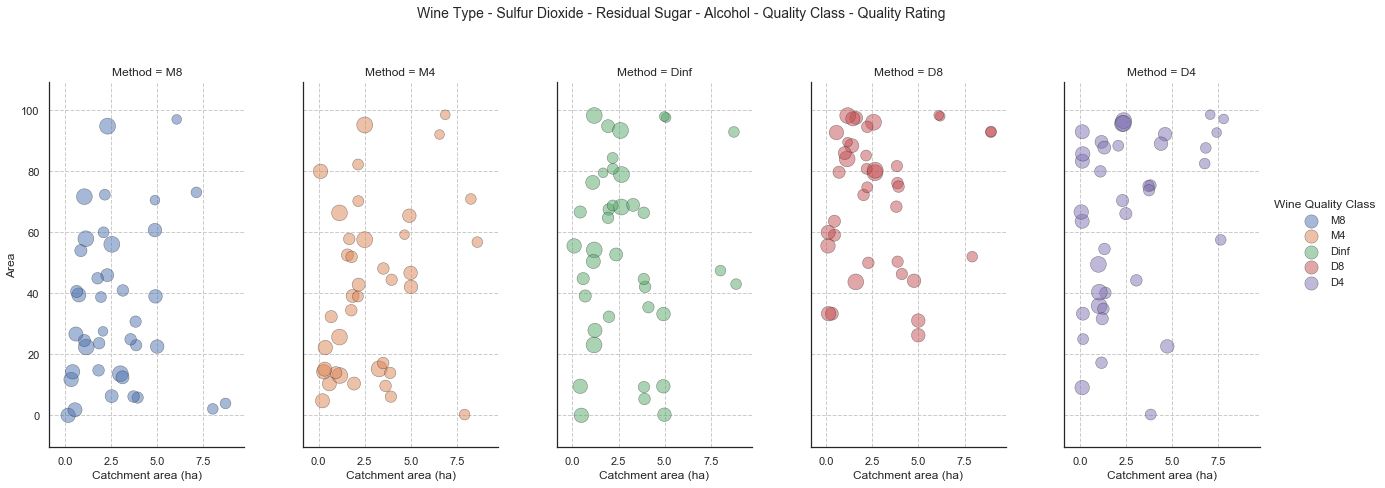

In [231]:
g = sns.FacetGrid(gh_data,  
                  col="Method",       
                  hue='Method')

g.map(plt.scatter,  
      "Catchment area (ha)",
      "Area",      
      alpha=0.5, 
      edgecolor='k', 
      linewidth=0.5, 
      s=gh_data['Mean slope']*5000)

fig = g.fig 
fig.set_size_inches(18, 8)
fig.subplots_adjust(top=0.85, wspace=0.3)
fig.suptitle('Wine Type - Sulfur Dioxide - Residual Sugar - Alcohol - Quality Class - Quality Rating', fontsize=14)
g.add_legend(title='Wine Quality Class')

In [ ]:
g = sns.FacetGrid(area_data, col="Method", margin_titles=True, height=4)
g.map(plt.scatter, "total_bill", "tip", color="#338844", edgecolor="white", s=50, lw=1)

In [63]:
sns.set(style = 'whitegrid')
ax = sns.distplot(gh_data["D4 0.5m"], rug=True, rug_kws={"color": "g"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1, "color": "g"},fit=stats.gamma)

NameError: name 'stats' is not defined

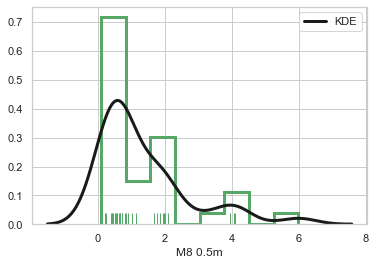

In [262]:
sns.set(style = 'whitegrid')
ax = sns.distplot(gh_data["M8 0.5m"], rug=True, rug_kws={"color": "g"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1, "color": "g"})

(-1, 100)

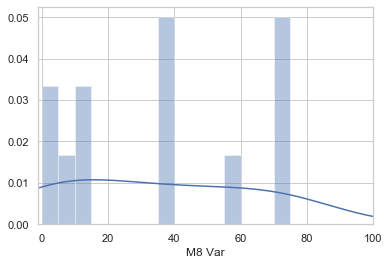

In [277]:
sns.set(style = 'whitegrid')
plot = sns.distplot(gh_data["M8 Var"], bins=15)
plot.set_xlim(-1, 100)

(-1, 10)

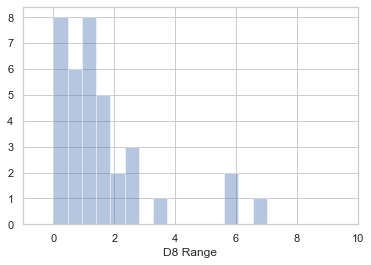

In [154]:
sns.set(style = 'whitegrid')
plot = sns.distplot(gh_data["D8 Range"], bins=15, norm_hist = False, kde = False)
plot.set_xlim(-1, 10)

Text(0.5, 1.0, 'Change in downstream values for DFME and PC')

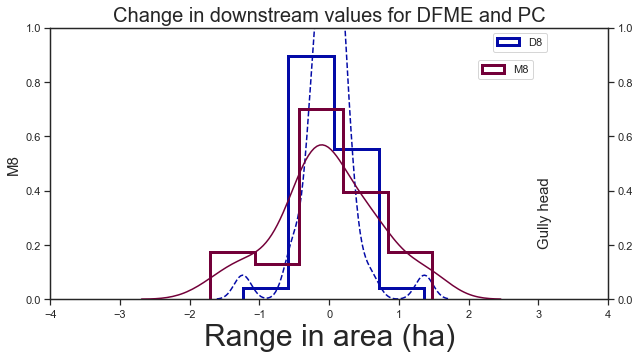

In [243]:
sns.set(style = 'ticks')
fig, ax1 = plt.subplots(figsize = (10, 5))
sns.distplot(gh_data["M8 Difference"], bins=4, color = 'xkcd:cobalt blue', hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1})
ax1.set_ylabel('M8', fontsize=15)
ax1.lines[0].set_linestyle("--")
ax1.set_ylim(0, 1)
ax1.set_xlabel('Range in area (ha)', fontsize = 30)
ax1.legend(['D8'],bbox_to_anchor=(0.4, 0.6, 0.5, 0.4))
ax1.set_xlim(-4, 4)
ax2 = ax1.twinx()
ax2.set_ylim(0, 1)
ax2.set_xlim(-4, 4)
sns.distplot(gh_data["D4 Difference"], bins=5, color='xkcd:merlot', hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1})
#ax2.set_ylabel('PC (rad / 100m)', fontsize = 15)
ax2.legend(['M8'],bbox_to_anchor=(0.375, 0.5, 0.5, 0.4))

ax1.text(3, 0.2, r'Gully head', fontsize=15, rotation = 90)
plt.title('Change in downstream values for DFME and PC', fontsize = 20)

Text(0.5, 1.0, 'Range of area calculations across three resolutions (0.5m, 1m and 2m)')

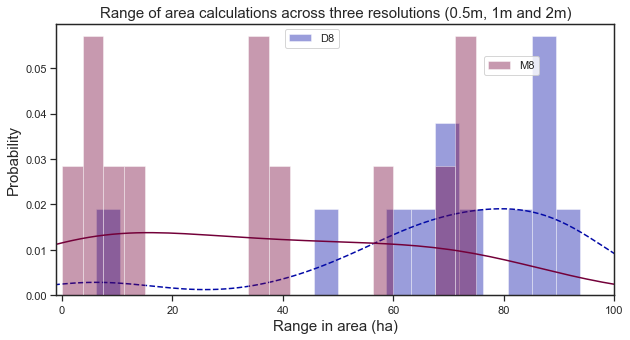

In [278]:
sns.set(style = 'ticks')
method_1 = 'D8'
method_2 = 'M8'
fig, ax1 = plt.subplots(figsize = (10, 5))
sns.distplot(gh_data[method_1 + ' Var'], bins=20, color = 'xkcd:cobalt blue')
ax1.set_ylabel('Probability', fontsize=15)
ax1.lines[0].set_linestyle("--")
#ax1.set_ylim(0, 1)
ax1.set_xlabel('Range in area (ha)', fontsize = 15)
ax1.legend([method_1],bbox_to_anchor=(0.4, 0.6, 0.5, 0.4))
ax1.set_xlim(-1, 100)
ax2 = ax1.twinx()
#ax2.set_ylim(0, 1)
ax2.set_xlim(-1, 100)
sns.distplot(gh_data[method_2 + ' Var'], bins=20, color='xkcd:merlot')
#ax2.set_ylabel('PC (rad / 100m)', fontsize = 15)
ax2.legend([method_2],bbox_to_anchor=(0.375, 0.5, 0.5, 0.4))
ax2.set_yticks([])
#ax1.text(3, 0.2, r'Gully head', fontsize=15, rotation = 90)
plt.title('Range of area calculations across three resolutions (0.5m, 1m and 2m)', fontsize = 15)

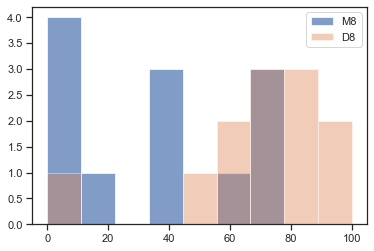

In [276]:

bins = np.linspace(0, 100, 10)

plt.hist(gh_data["M8 Var"].values, bins, alpha=0.7, label='M8')
plt.hist(gh_data["D8 Var"].values, bins, alpha=0.4, label='D8')
plt.legend(loc='upper right')
plt.show()


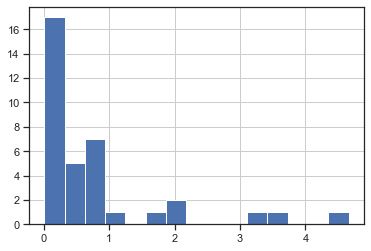

In [109]:
hist = sub_m8.hist(bins = 15)

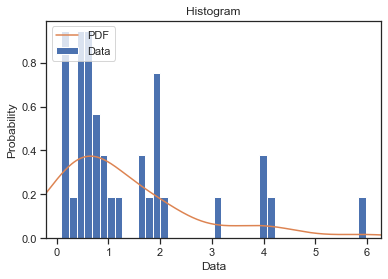

In [252]:
import scipy.stats as st
x = gh_data["M8 0.5m"]
plt.hist(x, density=True, bins=40, label="Data")
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 301)
kde = st.gaussian_kde(x)
plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
plt.legend(loc="upper left")
plt.ylabel('Probability')
plt.xlabel('Data')
plt.title("Histogram");

In [ ]:
df['A'].hist()
df['B'].hist()